* Function
    * Raise_Question
    * Find_best_question
    * Partition
    * Build_tree
    * Predict
* Class
    * Attribute Node
    * Leaf Node

# Data Preparation - reorganize the data
1. label should be the last column
2. make sure that catagorical data are in string format, numerical data are in int or float format

In [1]:
# Import lib
# ===========================================================
import csv
import pandas as pd
import numpy as np
import random
import time
import matplotlib.pyplot as plt
import collections
import math
import sys
from tqdm import tqdm
from time import sleep

In [2]:
# Initialize useful data
# ===========================================================
with open('clinvar_conflicting_clean.csv', 'r') as f:
    reader = csv.reader(f)
    temp_rows = list(reader)
df = pd.read_csv('clinvar_conflicting_clean.csv', low_memory=False)
columns_to_change = ['ORIGIN', 'EXON', 'INTRON', 'STRAND', 'LoFtool', 'CADD_PHRED', 'CADD_RAW', 'BLOSUM62']
df[['CLNVI', 'MC', 'SYMBOL', 'Feature_type', 'Feature', 'BIOTYPE', 
 'cDNA_position', 'CDS_position', 'Protein_position', 'Amino_acids', 'Codons', 
 'BAM_EDIT', 'SIFT', 'PolyPhen']] = df[['CLNVI', 'MC', 'SYMBOL', 'Feature_type', 'Feature', 'BIOTYPE', 
 'cDNA_position', 'CDS_position', 'Protein_position', 'Amino_acids', 'Codons', 
 'BAM_EDIT', 'SIFT', 'PolyPhen']].fillna(value="null")
df = df.sample(n = df.shape[0])
all_rows = df.values.tolist()
row_num = len(all_rows)

# Classification with Supervised Learning: Decision Tree

In [8]:
# Decision stump part for Adaboost
# ===========================================================
def is_numeric(value):
    return isinstance(value, int) or isinstance(value, float)

# === LeafNode is the prediction result of this branch ===
class LeafNode:
    def __init__(self, rows):
        labels = [row[-1] for row in rows]
        self.prediction = collections.Counter(labels)

# === DecisionNode is an attribute / question used to partition the data ===
class DecisionNode:
    def __init__(self, question = None, left_branch = None, right_branch = None):
        self.question = question
        self.left_branch = left_branch
        self.right_branch = right_branch
    
class DecisionTree:
    def __init__(self, training_attribute, training_data, method = "CART"):
        self.attribute = training_attribute     # takein attribute and data separately
        self.train = training_data[1:]
        self.row_num = len(self.train)
        self.column_num = len(self.attribute)
        self.method = method.upper()            # convert to upper case for general use
        self.labels = self.uniq_val(-1)
        if self.method not in ["C4.5", "CART", "HYBRID"]:
            print("Error: Please choose a valid method!")
            return None
        self.root = self.build_tree(self.train)
    
    def uniq_val(self, column):
        return set([self.train[i][column] for i in range(len(self.train))])
    
    # when raising a question.
    # if it's a categorical attribute, we simply iterate all categories
    # if it's a numeric attribute, we iterate the set of possible numeric values 
    class Question:
        def __init__(self, column, ref_value, attribute):
            self.column = column
            self.ref_value = ref_value if ref_value else "None"
            self.attri = attribute

        def match(self, row):
            if is_numeric(self.ref_value):
                try:
                    return row[self.column] >= self.ref_value
                except:
                    print("Error occured in ", row)
                    return True
            else:
                return row[self.column] == self.ref_value

        def __repr__(self):
            operand = ">=" if is_numeric(self.ref_value) else "=="
            return "Is %s %s %s?" % (self.attri[self.column], operand, str(self.ref_value))
    
    # === Method 1 - C4.5 ===
    def entropy(self, rows):
        # === Bits used to store the information ===
        labels = [row[-1] for row in rows]
        frequency = collections.Counter(labels).values()
        pop = sum(frequency)
        H = 0
        for f in frequency:
            p = f / pop
            H -= p * math.log(p, 2)
        return H
    
    # === Method 2 - CART ===
    def gini(self, rows):
        # === Probability of misclassifying any of your label, which is impurity ===
        labels = [row[-1] for row in rows]
        frequency = collections.Counter(labels).values()
        pop = sum(frequency)
        gini = 1
        for f in frequency:
            p = f / pop
            gini -= p ** 2
        return gini
    
    # === Calculate Gain Info ===
    def info(self, branches, root):
        # === Objective: to find the best question which can maximize info ===
        root_size = float(len(root))
        if self.method == "C4.5":  # Here I pick the GainRatio Approach
            root_uncertainty = self.entropy(root)
            gain_info = root_uncertainty
            split_info = 0
            for branch in branches:
                if not branch: continue
                gain_info -= len(branch) / root_size * self.entropy(branch)
                split_info -= float(len(branch)) / root_size * math.log(float(len(branch)) / root_size)
#                 print(gain_info, split_info)
            return gain_info / split_info
        elif self.method == "CART":
            root_uncertainty = self.gini(root)
            gain_info = root_uncertainty
            for branch in branches:
                if not branch: continue
                gain_info -= len(branch) / root_size * self.gini(branch)
            return gain_info
        elif self.method == "HYBRID":
            pass
        pass
    
    # === Here I only do Binary Partitions ===
    def partition(self, rows, question):
        true_rows = []
        false_rows = []
        for row in rows:
            if question.match(row):
                true_rows.append(row)
            else:
                false_rows.append(row)
        return true_rows, false_rows
    
    def find_best_question(self, rows):
        max_info_attenuation = 0
        # === Iterate through all question candidates ===
        # === TODO: Maybe Iteration here can be optimized ===
        for col in range(self.column_num - 1): # minus 1 to avoid using the label as attribute
            ref_candidates = self.uniq_val(col)
            for ref_value in ref_candidates:
                if ref_value == "null": continue # avoid using null values to generate a question
                q = self.Question(col, ref_value, self.attribute)
                temp_true_rows, temp_false_rows = self.partition(rows, q)
                temp_info_attenuation = self.info([temp_true_rows, temp_false_rows], rows)
                if temp_info_attenuation >= max_info_attenuation:
                    max_info_attenuation = temp_info_attenuation
                    best_question = q
        return max_info_attenuation, best_question
        
    # === Input rows of data with attributes and labels ===
    def build_tree(self, rows):
        # === Assign all rows as root of the whole decision tree ===
        # === We have met the leaf node if gini(rows) is 0 or no question candidates left ===
        gain, q = self.find_best_question(rows)
        if gain == 0:
            return LeafNode(rows)
        true_rows, false_rows = self.partition(rows, q)
        # === Recursion after we have found a optimal question ===
        return DecisionNode(q, self.build_tree(true_rows), self.build_tree(false_rows))
    
    # === Input a row of data with attributes (and no label), predict its label with our decision tree ===
    # === Actually it can contain a label, we just don't use it ===
    # === walk down the decision tree until we reach the leaf node ===
    def classify(self, row, node):
        if isinstance(node, LeafNode):
#             print("===", node.prediction)
            return node.prediction
        
        if node.question.match(row):
#             print(node.question, True)
            return self.classify(row, node.left_branch)
        else:
#             print(node.question, False)
            return self.classify(row, node.right_branch)
    
    def print_tree(self, node, spacing=""):
        # Base case: we've reached a leaf
        if isinstance(node, LeafNode):
            print (spacing + "Predict", node.prediction)
            return

        # Print the question at this node
        print (spacing + str(node.question))

        # Call this function recursively on the true branch
        print (spacing + '--> True:')
        self.print_tree(node.left_branch, spacing + "  ")

        # Call this function recursively on the false branch
        print (spacing + '--> False:')
        self.print_tree(node.right_branch, spacing + "  ")


In [9]:
# Divide whole dataset into training set and testing set
# ===========================================================
training_percentage = 0.01  # percent of partition of training dataset
training_size = int(row_num * training_percentage)
testing_size = row_num - training_size
training_attribute = list(df.columns)
training_data = all_rows[: training_size]  # training data should include header row
testing_data = all_rows[training_size: ]   # testing data don't need to include header row

In [10]:
# Training
# ===========================================================
start = time.time()
tree = DecisionTree(training_attribute, training_data, "CART")
# print(tree.info([[1,1,1,1,1,1], [0,0,0,0,0,0]], [1,1,1,1,1,1,0,0,0,0,0,0]))
# tree.gini(training_data[1:])
# leaf = LeafNode([1,2,2,2,1,2])
# print(leaf.prediction())
# tree.print_tree(tree.root)

In [11]:
# Testing
# ===========================================================
accuracy = []
for row in testing_data:
    classification = tree.classify(row, tree.root)
    if len(classification) == 1:
#         print("======", row, tree.classify(row, tree.root).get(row[-1], 0))
        accuracy.append(int(classification.get(row[-1], 0) > 0))
    else:
#         print("======", row, tree.classify(row, tree.root).get(row[-1], 0))
        tot = sum(classification.values())
        accuracy.append(classification.get(row[-1], 0) / tot)
print(sum(accuracy) / len(accuracy))
end = time.time()
print(end - start)

0.7145978276027705
65.63319706916809


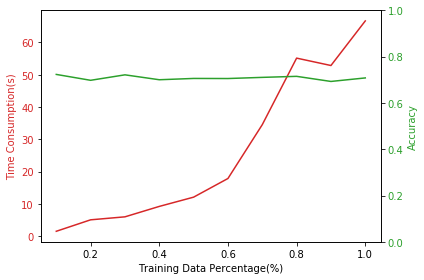

In [27]:
result = np.array([[0.1, 0.7233235569614422, 1.5288949012756348], 
[0.2, 0.6979157059854284, 5.077696084976196], 
[0.3, 0.7215392426876741, 6.001860857009888], 
[0.4, 0.7003295958600295, 9.227790832519531], 
[0.5, 0.7059494627137197, 12.09618592262268], 
[0.6, 0.7055882216769295, 17.873859167099], 
[0.7, 0.7105604646851634, 34.53915524482727], 
[0.8, 0.7150169329024078, 55.14473509788513], 
[0.9, 0.6929816414352497, 52.855583906173706], 
[1, 0.7081829028309342, 66.66273093223572]])
[percentage, acc, time_cost] = result.transpose()

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Training Data Percentage(%)')
ax1.set_ylabel('Time Consumption(s)', color=color)
ax1.plot(percentage, time_cost, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:green'
ax2.set_ylabel('Accuracy', color=color)  # we already handled the x-label with ax1
ax2.plot(percentage, acc, color=color)
ax2.tick_params(axis='y', labelcolor=color)
plt.ylim(0, 1)
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()
# _ = plt.plot(result[0], result[1], 'g-', result[0], result[2], 'y-')
# _ = plt.xlabel('training data percentage')
# _ = plt.ylabel('training data percentage')

In [5]:
# === test cell ===
'''out = []
for col in range(len(training_attribute)):
    name = training_attribute[col]
#     print(type(df[col][0]))
#     for i in range(row_num):
#         a = type(df[col][i])
    temp = set()
    temp2 = set()
    for i in range(row_num):
        temp.add(type(df[name][i]))
        temp2.add(df[name][i])
    if len(temp) >= 0:
        out.append(name)
        print(col, name, list(temp)[:min(10, len(temp))], list(temp2)[:min(10, len(temp))])
print(out)'''




'out = []\nfor col in range(len(training_attribute)):\n    name = training_attribute[col]\n#     print(type(df[col][0]))\n#     for i in range(row_num):\n#         a = type(df[col][i])\n    temp = set()\n    temp2 = set()\n    for i in range(row_num):\n        temp.add(type(df[name][i]))\n        temp2.add(df[name][i])\n    if len(temp) >= 0:\n        out.append(name)\n        print(col, name, list(temp)[:min(10, len(temp))], list(temp2)[:min(10, len(temp))])\nprint(out)'

In [6]:
# === toy data set ===
training_data = [
    ['Color', 'Diameter', 'Label'],
    ['Green', 3, 'Apple'],
    ['Yellow', 3, 'Apple'],
    ['Red', 1, 'Grape'],
    ['Red', 1, 'Grape'],
    ['Yellow', 3, 'Lemon'],
]
testing_data = [
    ['Red', 2, 'Grape'],
    ['Yellow', 3.5, 'Apple'],
    ['Green', 3, 'Apple']
]